# Realtion between unemployment rates and safety needs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from helpers import *
import plotly.express as px
from datetime import datetime
import statsmodels.formula.api as smf
import re
from sklearn.linear_model import LinearRegression



In [3]:
#import data
dfeu = pd.read_csv('DATA/eu.tsv',sep='\t')
countries = pd.read_csv('DATA/countries_list.csv.xls')


In [4]:
dfts=process_eu_unemployment(dfeu,countries,0)

/Users/test/Documents/GitHub/ada-2023-project-bobeast/helpers.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfts['Date']=pd.to_datetime(dfts['Date'].apply(lambda x : x.replace('M','/')))


In [5]:
dfts=dfts[~(dfts['Country'].isin(['United States','Japan','Turkey']))]
dfts

,Country,age,unit,sex,Country_code,Date,Value,Year,Month
0,Austria,TOTAL,PC_ACT,F,AT,2020-07-01,4.5,2020,7
1,Austria,TOTAL,PC_ACT,M,AT,2020-07-01,5.8,2020,7
2,Austria,TOTAL,PC_ACT,T,AT,2020-07-01,5.2,2020,7
3,Austria,TOTAL,THS_PER,F,AT,2020-07-01,96.0,2020,7
4,Austria,TOTAL,THS_PER,M,AT,2020-07-01,142.0,2020,7
...,...,...,...,...,...,...,...,...,...
5272,United Kingdom,Y_LT25,PC_ACT,M,UK,2019-11-01,12.3,2019,11
5273,United Kingdom,Y_LT25,PC_ACT,T,UK,2019-11-01,10.9,2019,11
5274,United Kingdom,Y_LT25,THS_PER,F,UK,2019-11-01,183.0,2019,11
5275,United Kingdom,Y_LT25,THS_PER,M,UK,2019-11-01,268.0,2019,11


# General look over all EU Data

### Distribution amongst age groups

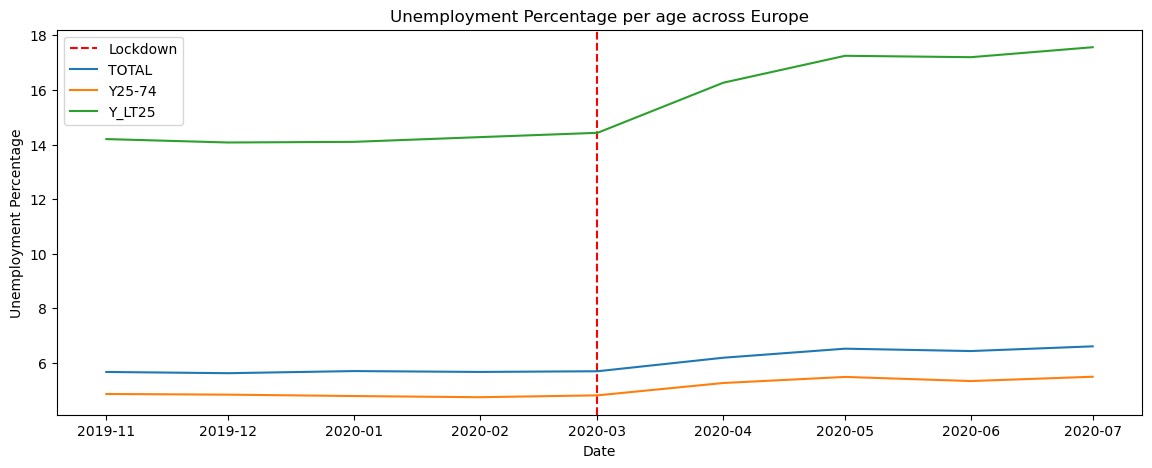

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     13.76
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           2.38e-05
Time:                        11:30:38   Log-Likelihood:                -66.707
No. Observations:                  27   AIC:                             141.4
Df Residuals:                      23   BIC:                             146.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.2134      0.895      9.174      0.000       6.361      10.066
age[TOTAL]:lockdown     -1.9216      1.651     -1.164      0.256      -5.337       1.493
age[Y25-74]:lockdown    -2.9327      1.651     -1.776      0.089      -6.348       0.482
age[Y_LT25]:lockdown     8.3298      1.651      5.046      0.000       4.915      11.745
==============================================================================
Omnibus:                        5.424   Durbin-Watson:                   0.595
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                4.219
Skew:                           0.965   Prob(JB):                        0.121
Kurtosis:                       3.168   Cond. No.                         3.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
res_age=unemployment_across_groups(dfts,'age',(14,5))
regression_age=regression_helper(res_age[0],'age')
regression_age.summary()

TypeError: datetime64 type does not support sum operations

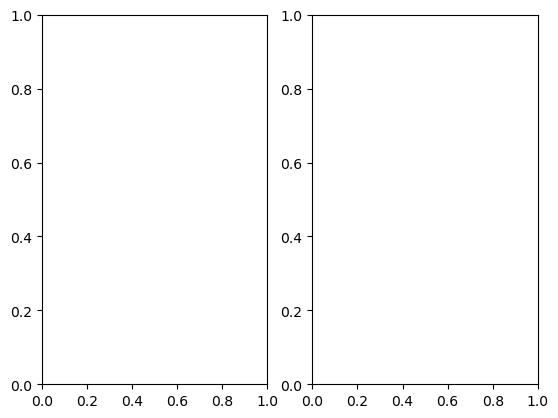

In [6]:
plot_pies(res_age[1],'age','TOTAL')

### Distribution amongst sexes

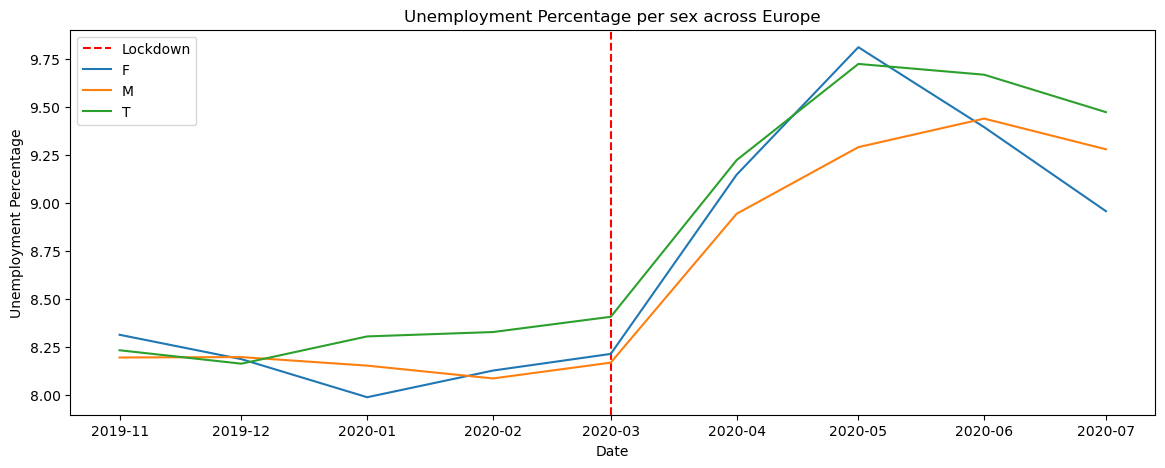

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     12.95
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           3.67e-05
Time:                        10:50:39   Log-Likelihood:                -11.484
No. Observations:                  27   AIC:                             30.97
Df Residuals:                      23   BIC:                             36.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.1880      0.116     70.708      0.000       7.948       8.428
sex[F]:lockdown     0.9149      0.214      4.285      0.000       0.473       1.357
sex[M]:lockdown     0.8344      0.214      3.908      0.001       0.393       1.276
sex[T]:lockdown     1.1091      0.214      5.194      0.000       0.667       1.551
==============================================================================
Omnibus:                        8.543   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                6.634
Skew:                          -1.046   Prob(JB):                       0.0363
Kurtosis:                       4.232   Cond. No.                         3.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
res_sex=unemployment_across_groups(dfts,'sex',(14,5))
regression_sex=regression_helper(res_sex[0],'sex')
regression_sex.summary()

C:\Users\Kamal\OneDrive\Documents\GitHub\ada-2023-project-bobeast\helpers.py:130: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pie=df_pie.groupby(group).sum().drop(total)
C:\Users\Kamal\OneDrive\Documents\GitHub\ada-2023-project-bobeast\helpers.py:130: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pie=df_pie.groupby(group).sum().drop(total)


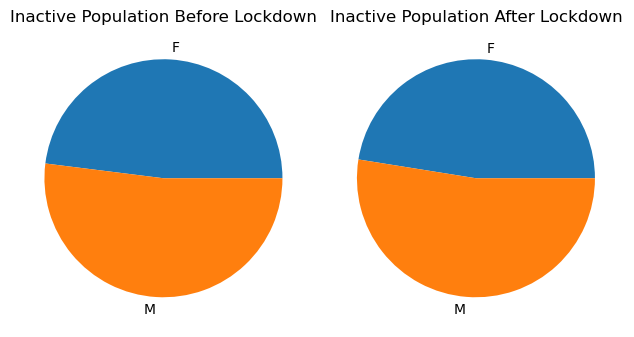

In [ ]:
plot_pies(res_sex[1],'sex','T')

## Distribution amongst Countries

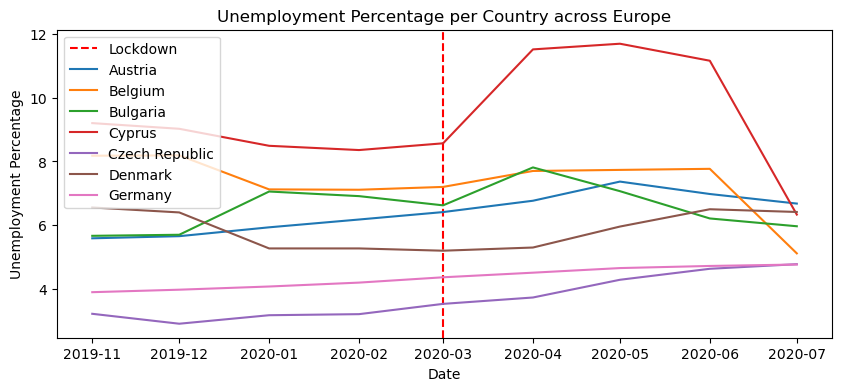

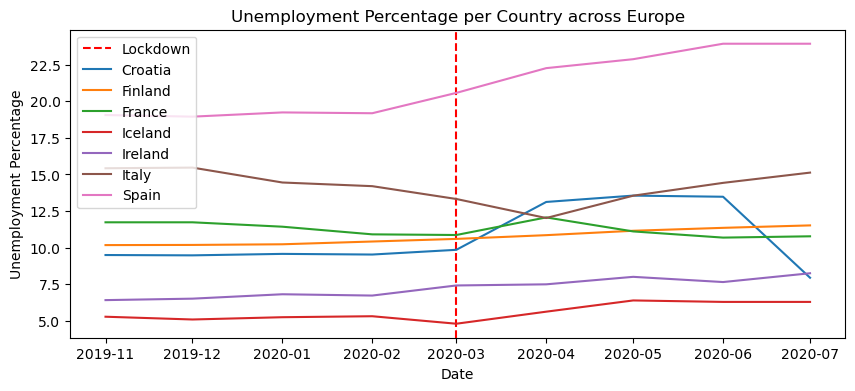

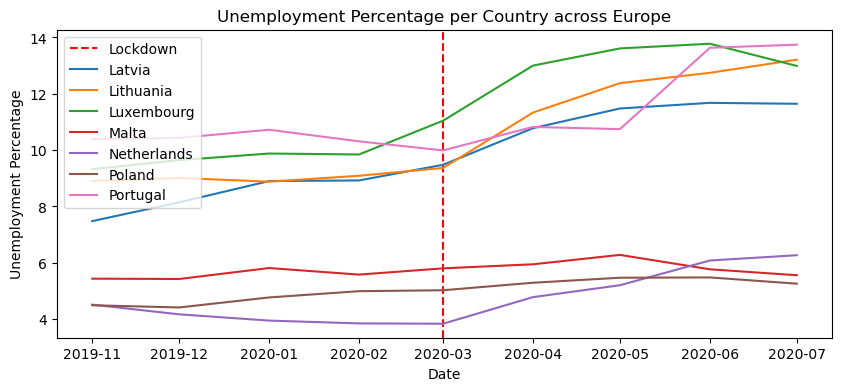

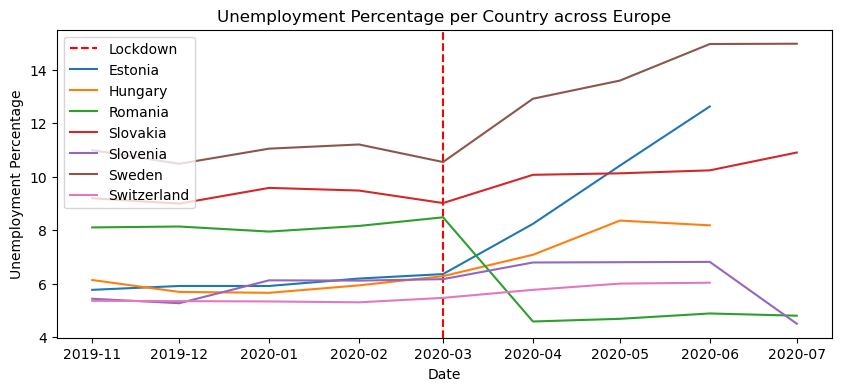

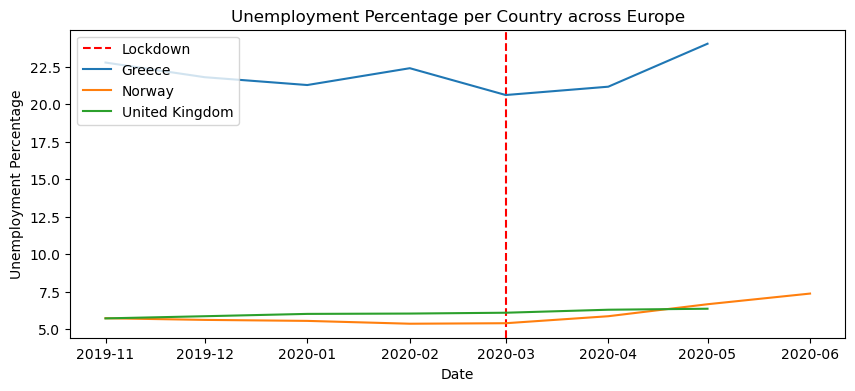

In [ ]:
splits=np.split((dfts['Country'].unique())[:-3],4)
splits.append(dfts['Country'].unique()[-3:])
dfs_country=[dfts[dfts['Country'].isin(s)] for s in splits]
res_country=[]
for df_country in dfs_country:
    r_group=unemployment_across_groups(df_country,'Country',size=(10,4))
    res_country.append(r_group)

In [ ]:
coefs=[]
for r in res_country:
    res=regression_helper(r[0],'Country')
    #print(res.summary())
    coefs.append(res.params)

In [ ]:
df_coefs=pd.DataFrame()
for c in coefs:
    df_coefs=pd.concat([df_coefs,c])
    df_coefs=df_coefs.drop('Intercept',axis=0)
df_coefs.columns=['coefs']

df_coefs.index=df_coefs.index.astype(str)
new_index=[]
for i in df_coefs.index:
    i=str(i).split('Country[')[1]
    i=i.split(']:lockdown')
    new_index.append(i[0])
df_coefs.index=new_index
df_coefs=df_coefs.sort_values('coefs')
df_coefs

,coefs
Iceland,-5.123214
United Kingdom,-4.930556
Norway,-4.858333
Ireland,-3.243214
Netherlands,-2.170079
Poland,-2.098968
Romania,-1.826349
Czech Republic,-1.754229
Malta,-1.532302
Switzerland,-1.495238


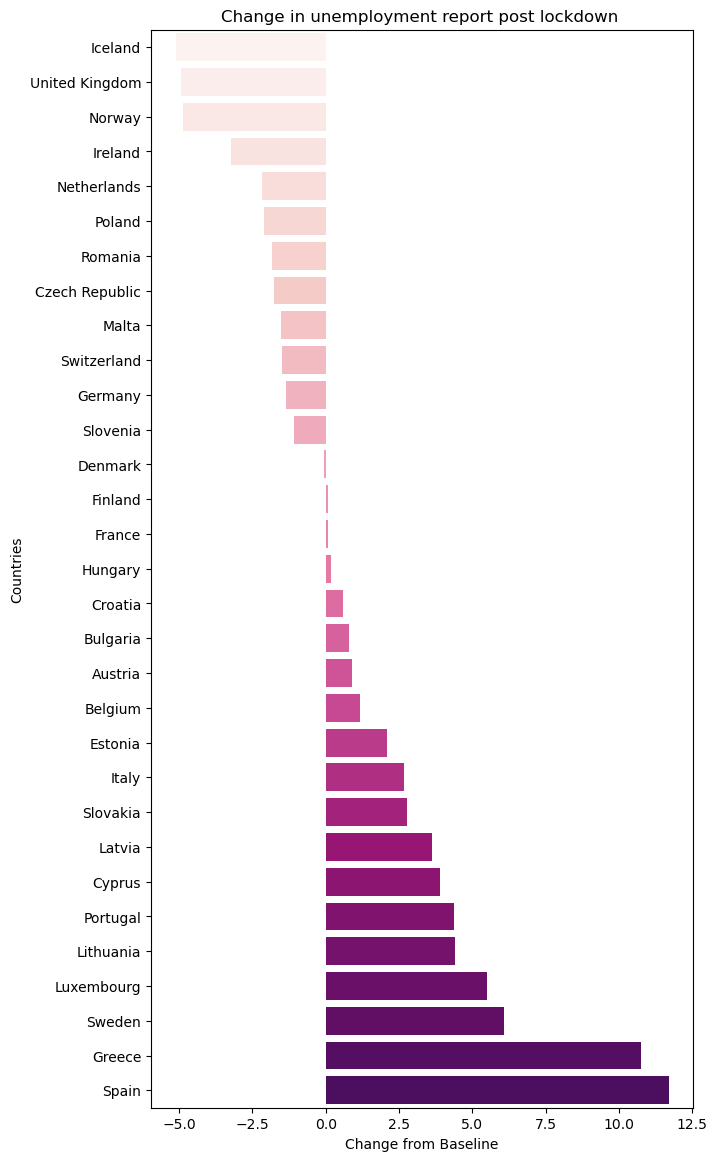

In [ ]:
plt.figure(figsize=(7,14))
sns.barplot(y=df_coefs.index,x=df_coefs.values.flatten(),palette='RdPu')
plt.ylabel('Countries')
plt.xlabel('Change from Baseline')
plt.title('Change in unemployment report post lockdown ')
plt.show()

**Difference in Differences**

In [6]:
dftd=process_eu_unemployment(dfeu,countries,1)

/Users/test/Documents/GitHub/ada-2023-project-bobeast/helpers.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfts['Date']=pd.to_datetime(dfts['Date'].apply(lambda x : x.replace('M','/')))


In [22]:
df_italy = dftd[dftd['Country']=='Italy']
df_italy_m = split_group(df_italy, '2019-01-01', '2019-07-01', '2020-01-01', '2020-07-01', '2019-03-01', '2020-03-01')
df_italy_m


,Date,Value,g,t,gt
7376,2019-07-01,9.7,0,1,0
7965,2019-06-01,9.6,0,1,0
8554,2019-05-01,10.1,0,1,0
9143,2019-04-01,10.3,0,1,0
9732,2019-03-01,10.4,0,1,0
10321,2019-02-01,10.4,0,0,0
10910,2019-01-01,10.4,0,0,0
308,2020-07-01,9.7,1,1,1
897,2020-06-01,9.3,1,1,1
1486,2020-05-01,8.5,1,1,1


In [23]:
lr = LinearRegression()
X = df_italy_m[['g', 't', 'gt']]
y = df_italy_m.Value

lr.fit(X, y)
lr.coef_

array([-0.9 , -0.38, -0.46])

We observe a rise in unemployment after treatment (covid) with respect to the group (g*t) is (0.0083), showing an increase in unemployment due to the pandemic. Taking into account normal fluctuation that could occur during a year.

**DiD for all European countries**

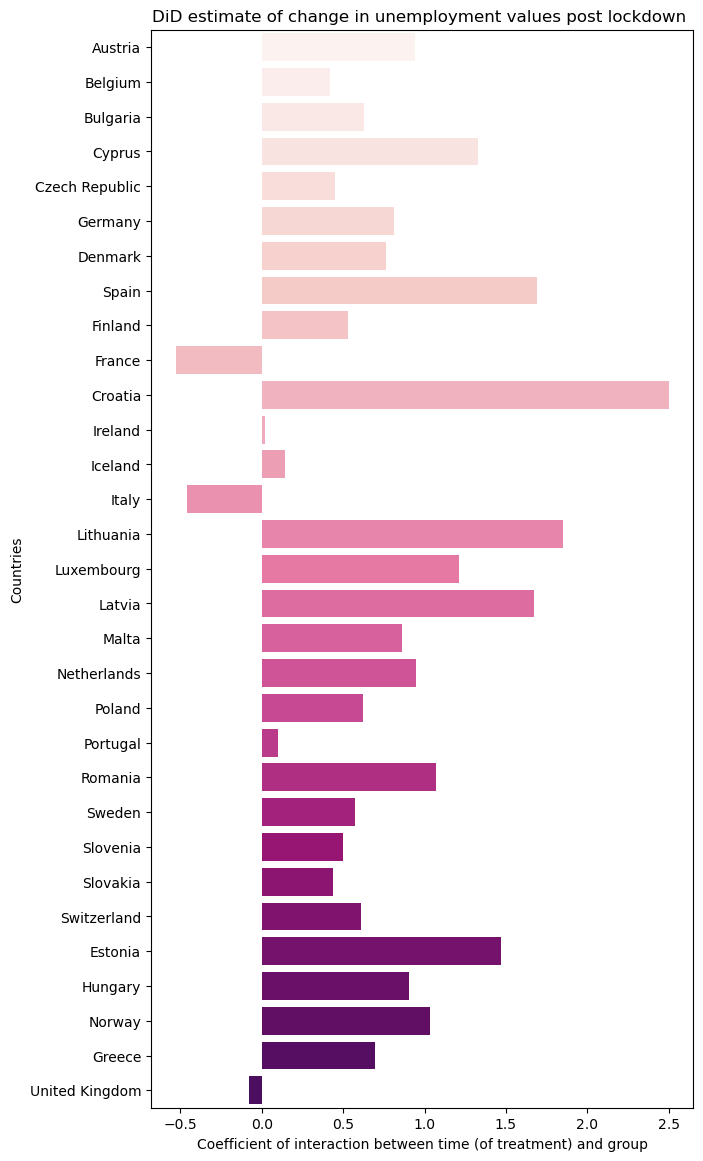

In [24]:
values = []
dftd=dftd[~(dftd['Country'].isin(['United States','Japan','Turkey']))]
for country in dftd['Country'].unique():
    dfcountry = dftd[dftd['Country']==country]
    dfcountry = split_group(dfcountry, '2019-01-01', '2019-07-01', '2020-01-01', '2020-07-01', '2019-03-01', '2020-03-01')
    lr = LinearRegression()
    X = dfcountry[['g', 't', 'gt']]
    y = dfcountry.Value
    lr.fit(X, y)
    values.append(lr.coef_[2]) 
plt.figure(figsize=(7,14))
sns.barplot(y=dftd['Country'].unique(),x=values,palette='RdPu')
plt.ylabel('Countries')
plt.xlabel('Coefficient of interaction between time (of treatment) and group')
plt.title('DiD estimate of change in unemployment values post lockdown ')
plt.show()

We observe a rise in unemployment due to the pandemic in almost all european countries.